In [1]:
# std libs
import re

# numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

# scipy
from scipy.spatial.distance import pdist, squareform
import scipy.cluster.hierarchy as hc

# seaborn -- for better looking plots
import seaborn as sns

# pandas 
import pandas as pd

# rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdmolops
from rdkit.Chem import Descriptors
from rdkit import DataStructs
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Crippen

In [2]:
james_data = pd.read_excel('2016.06.09_Structure and Induction.xlsx')
james_data.columns = ['name', 'smiles', 'z81', 'z82', 'z83']
print james_data.shape
james_data[0:9]

(800, 5)


,name,smiles,z81,z82,z83
1,"1-HYDROXY-3,6,7-TRIMETHOXY-2,8-DIPRENYLXANTHONE",COc1cc2Oc3cc(OC)c(OC)c(CC=C(C)C)c3C(=O)c2c(O)c...,1.187198,-4.887129,-1.322174
2,1-MONOPALMITIN,CCCCCCCCCCCCCCCC(=O)OCC(O)CO,-11.635369,-5.665927,0.097163
3,"1,2alpha-EPOXYDEACETOXYDIHYDROGEDUNIN",CC1(C)C2C[C@@H](O)[C@]3(C)C(CC[C@@]4(C)[C@@H](...,-0.725625,-1.762620,-4.577752
4,"1,3-DIDEACETYL-7-DEACETOXY-7-OXOKHIVORIN",CC1(C)[C@H](O)C[C@H](O)[C@@]2(C)C1CC(=O)[C@]3(...,-1.353114,-2.564124,-4.545533
5,"1,7-DIDEACETOXY-1,7-DIOXO-3-DEACETYLKHIVORIN",CC1(C)[C@H](O)CC(=O)[C@@]2(C)C1CC(=O)[C@]3(C)C...,-0.932777,-2.319501,-2.845242
6,10-HYDROXYCAMPTOTHECIN,CC[C@@]1(O)C(=O)OCC2=C1C=C3N(Cc4cc5cc(O)ccc5nc...,3.077978,0.078013,0.467682
7,11a-ACETOXYPROGESTERONE,CC(=O)O[C@@H]1C[C@@]2(C)C(CC[C@@H]2C(=O)C)C3CC...,3.390333,12.949542,6.248535
8,12a-HYDROXY-5-DEOXYDEHYDROMUNDUSERONE,COc1ccc2C=C3c4cc(OC)c(OC)cc4OCC3(O)Oc2c1,3.799899,-0.053505,2.070715
9,12a-HYDROXY-9-DEMETHYLMUNDUSERONE-8-CARBOXYLIC...,COc1cc2OCC3Oc4c(ccc(O)c4C(=O)O)C(=O)C3(O)c2cc1OC,0.218433,0.294559,-0.268719


## Fixing the data: filling in a missing SMILES string for rutin and a bad SMILES string for coenzyme B12

In [3]:
# https://en.wikipedia.org/wiki/Rutin
RUTIN_SMILES = 'CC1C(C(C(C(O1)OCC2C(C(C(C(O2)OC3=C(OC4=CC(=CC(=C4C3=O)O)O)C5=CC(=C(C=C5)O)O)O)O)O)O)O)O'
B12_SMILES = 'NC(=O)C[C@@]8(C)[C@H](CCC(N)=O)C=2/N=C8/C(/C)=C1/[C@@H](CCC(N)=O)[C@](C)(CC(N)=O)[C@@](C)(N1[Co+]C#N)[C@@H]7/N=C(C(\C)=C3/N=C(/C=2)C(C)(C)[C@@H]3CCC(N)=O)[C@](C)(CCC(=O)NCC(C)OP([O-])(=O)O[C@@H]6[C@@H](CO)O[C@H](n5cnc4cc(C)c(C)cc45)[C@@H]6O)[C@H]7CC(N)=O'

print james_data.loc[694]
print james_data.iloc[271]

RUTIN_IDX = 694
B12_ABS_IDX = 271

james_data['smiles'].loc[RUTIN_IDX] = RUTIN_SMILES
james_data['smiles'].iloc[B12_ABS_IDX] = B12_SMILES

print james_data.loc[RUTIN_IDX]
print james_data.iloc[B12_ABS_IDX]

name      RUTOSIDE  (rutin)
smiles                  NaN
z81                 1.03469
z82                 4.06462
z83                0.864765
Name: 694, dtype: object
name                                           COENZYME B12
smiles    CC1CNC(=O)CCC2(C)C(CC(=O)N)C3N4=C2C(=C5C(CCC(=...
z81                                               -0.369046
z82                                                -3.49674
z83                                                0.147651
Name: 272, dtype: object
name                                      RUTOSIDE  (rutin)
smiles    CC1C(C(C(C(O1)OCC2C(C(C(C(O2)OC3=C(OC4=CC(=CC(...
z81                                                 1.03469
z82                                                 4.06462
z83                                                0.864765
Name: 694, dtype: object
name                                           COENZYME B12
smiles    NC(=O)C[C@@]8(C)[C@H](CCC(N)=O)C=2/N=C8/C(/C)=...
z81                                               -0.369046
z82  

/Users/curt/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## Finding fingerprints and chemical distances

In [4]:
# find fingerprint matrix (of shape 800 compounds by 2048 bits)

def find_fingerprint(smiles_str, bits = 2048):
    """
    Finds an RDKit fingerprint of a smiles string
    """
    try:
        mol = Chem.MolFromSmiles(smiles_str)
    except(TypeError):
        print smiles_str, type(smiles_str)
        raise
    
    if mol:
        fp = np.asarray(rdmolops.RDKFingerprint(mol, fpSize = bits), dtype = 'bool')
        
    else:
        fp = np.zeros(bits, dtype = 'bool')
    
    return fp

In [5]:
james_data['fingerprint'] = [find_fingerprint(smiles) for smiles in james_data['smiles']]

In [6]:
fingerprint_mat = np.vstack(james_data['fingerprint'])
print fingerprint_mat.shape

dist_mat = pdist(fingerprint_mat, 'jaccard')

dist_df = pd.DataFrame(squareform(dist_mat), 
                       index = james_data['name'], 
                       columns = james_data['name'])

# set a mask
mask = np.zeros_like(dist_df, dtype = 'bool')
mask[np.triu_indices_from(mask, k = 1)] = True

(800, 2048)


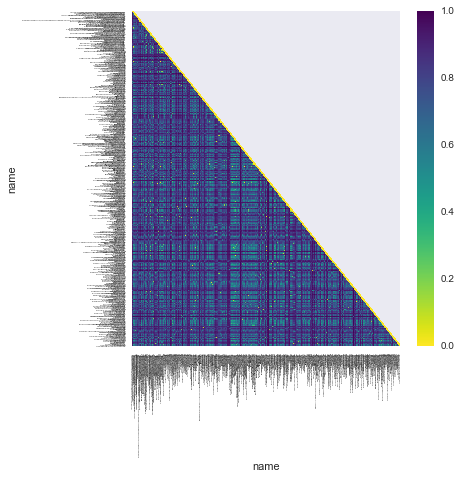

In [7]:
# plot fingerprint distance matrix

plt.figure(figsize=(6, 6))
ax = sns.heatmap(dist_df, mask=mask, cmap = cm.viridis_r, )
ax.tick_params(axis='both', which='major', labelsize=2)

## Finding distances in z-scores

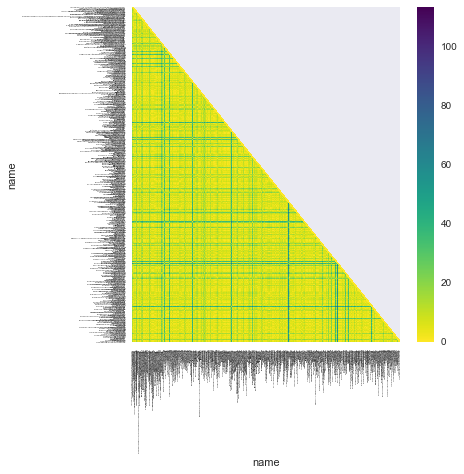

In [8]:
genexp_mat = np.asarray(james_data[['z81', 'z82', 'z83']])
genexp_distmat = pdist(genexp_mat, 'euclidean')

genexp_distdf = pd.DataFrame(squareform(genexp_distmat), 
                             index = james_data['name'], 
                             columns = james_data['name'])

# plot
plt.figure(figsize=(6, 6))
ax = sns.heatmap(genexp_distdf, mask=mask, cmap = cm.viridis_r, )
ax.tick_params(axis='both', which='major', labelsize=2)

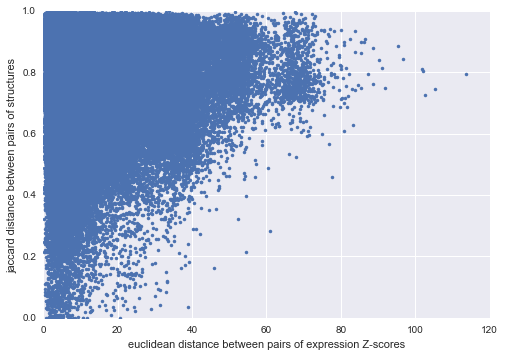

In [9]:
plt.plot(genexp_distmat, dist_mat, '.')
plt.gca().set_xlabel('euclidean distance between pairs of expression Z-scores')
plt.gca().set_ylabel('jaccard distance between pairs of structures')

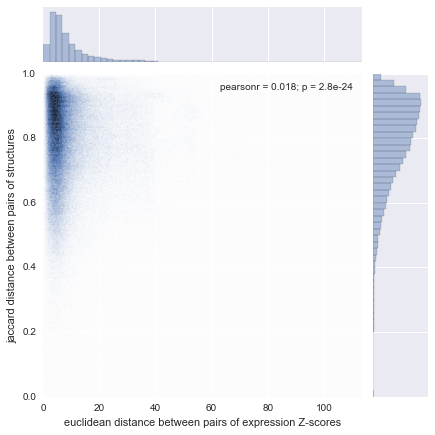

In [10]:
g = (sns.jointplot(x = genexp_distmat, 
                   y = dist_mat,
                   kind = 'hex').set_axis_labels('euclidean distance between pairs of expression Z-scores',
                                                 'jaccard distance between pairs of structures'))

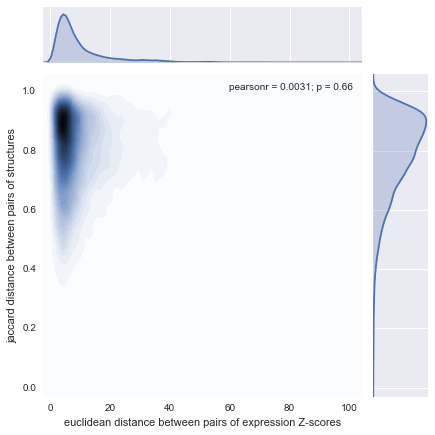

In [11]:
np.random.seed(0)
total_points = genexp_distmat.size
random_points = np.random.choice(range(total_points), size = 20000, replace = False)
g = (sns.jointplot(x = genexp_distmat.reshape(-1)[random_points], 
                   y = dist_mat.reshape(-1)[random_points],
                   kind = 'kde',
                   n_levels = 40).set_axis_labels('euclidean distance between pairs of expression Z-scores',
                                                 'jaccard distance between pairs of structures'))

## Looking just at z81 data so to be able to filter out insignificant Z scores

### All the z81 data

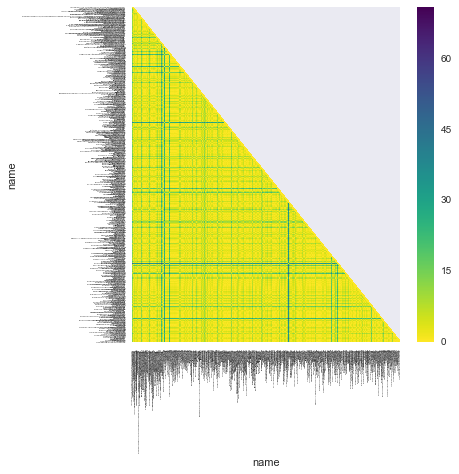

In [12]:
z81_mat = np.asarray(james_data[['z81']])
z81_distmat = pdist(z81_mat, 'euclidean')

z81_distdf = pd.DataFrame(squareform(z81_distmat), 
                             index = james_data['name'], 
                             columns = james_data['name'])

# plot
plt.figure(figsize=(6, 6))
ax = sns.heatmap(z81_distdf, mask=mask, cmap = cm.viridis_r, )
ax.tick_params(axis='both', which='major', labelsize=2)

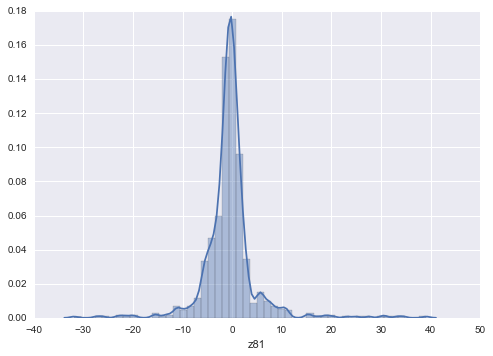

In [13]:
sns.distplot(james_data['z81'])

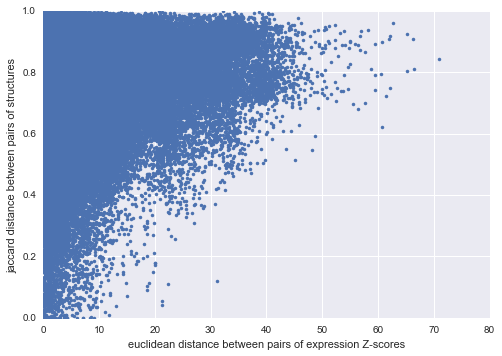

In [14]:
plt.plot(z81_distmat, dist_mat, '.')
plt.gca().set_xlabel('euclidean distance between pairs of expression Z-scores')
plt.gca().set_ylabel('jaccard distance between pairs of structures')

### only hits with z81

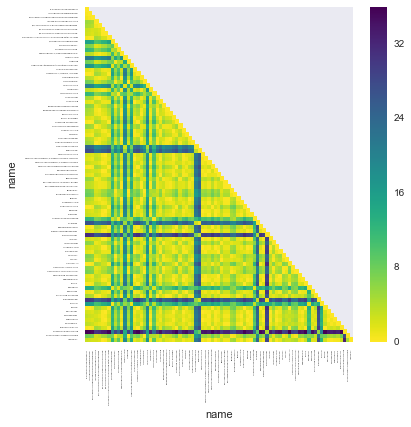

In [15]:
jdat_filt = james_data.query('z81 > 3')

z81f_mat = np.asarray(jdat_filt[['z81']])
z81f_distmat = pdist(z81f_mat, 'euclidean')

z81f_distdf = pd.DataFrame(squareform(z81f_distmat), 
                             index = jdat_filt['name'], 
                             columns = jdat_filt['name'])

# set a mask
mask = np.zeros_like(z81f_distdf, dtype = 'bool')
mask[np.triu_indices_from(mask, k = 1)] = True

# plot
plt.figure(figsize=(6, 6))
ax = sns.heatmap(z81f_distdf, mask=mask, cmap = cm.viridis_r, )
ax.tick_params(axis='both', which='major', labelsize=2)

In [16]:
dist_mat_filt = squareform(squareform(dist_mat)[jdat_filt.index, :][:, jdat_filt.index])

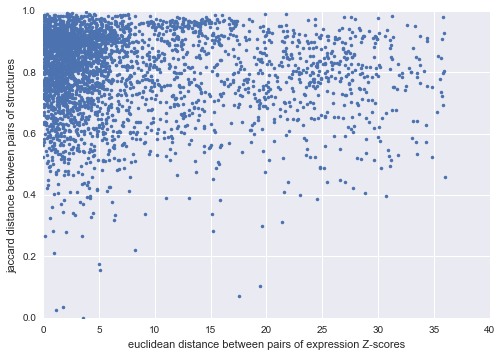

In [17]:
plt.plot(z81f_distmat, dist_mat_filt, '.')
plt.gca().set_xlabel('euclidean distance between pairs of expression Z-scores')
plt.gca().set_ylabel('jaccard distance between pairs of structures')

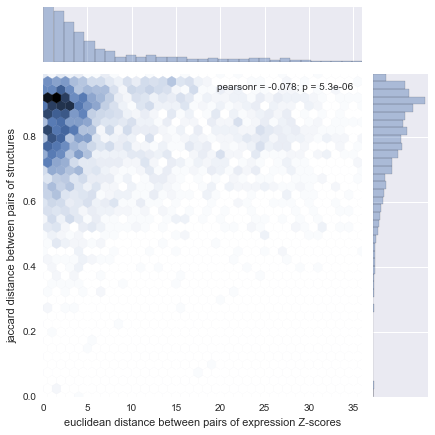

In [18]:
g = (sns.jointplot(x = z81f_distmat, 
                   y = dist_mat_filt,
                   kind = 'hex').set_axis_labels('euclidean distance between pairs of expression Z-scores',
                                                 'jaccard distance between pairs of structures'))

## Adding H-bond donor / acceptor and log P and looking at joint distributions

In [19]:
james_data['hba'] = [rdMolDescriptors.CalcNumHBA(Chem.MolFromSmiles(i)) for i in james_data['smiles']]
james_data['hbd'] = [rdMolDescriptors.CalcNumHBD(Chem.MolFromSmiles(i)) for i in james_data['smiles']]
james_data['logP'] = [Crippen.MolLogP(Chem.MolFromSmiles(i)) for i in james_data['smiles']]

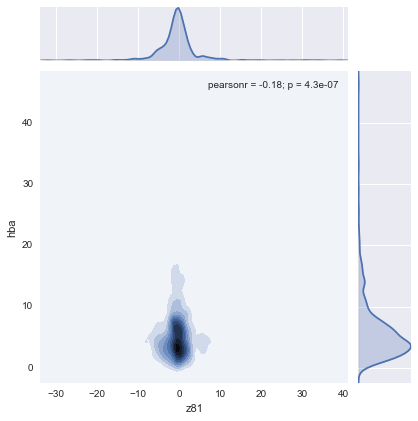

In [20]:
sns.jointplot('z81', 'hba', data = james_data, kind = 'kde')

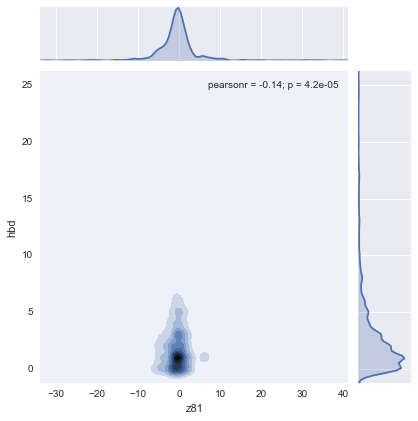

In [21]:
sns.jointplot('z81', 'hbd', data = james_data, kind = 'kde')

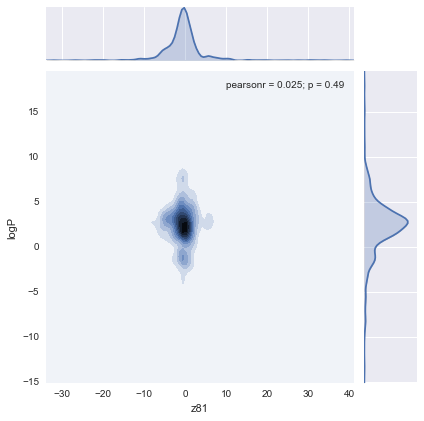

In [22]:
sns.jointplot('z81', 'logP', data = james_data, kind = 'kde')

## Basic heatmaps

In [23]:
james_data.columns

Index([u'name', u'smiles', u'z81', u'z82', u'z83', u'fingerprint', u'hba',
       u'hbd', u'logP'],
      dtype='object')

In [24]:
?sns.heatmap

In [30]:
trunc_james_data = james_data[['name', 'z81', 'z82', 'z83']]
trunc_james_data[0:9]

,name,z81,z82,z83
1,"1-HYDROXY-3,6,7-TRIMETHOXY-2,8-DIPRENYLXANTHONE",1.187198,-4.887129,-1.322174
2,1-MONOPALMITIN,-11.635369,-5.665927,0.097163
3,"1,2alpha-EPOXYDEACETOXYDIHYDROGEDUNIN",-0.725625,-1.762620,-4.577752
4,"1,3-DIDEACETYL-7-DEACETOXY-7-OXOKHIVORIN",-1.353114,-2.564124,-4.545533
5,"1,7-DIDEACETOXY-1,7-DIOXO-3-DEACETYLKHIVORIN",-0.932777,-2.319501,-2.845242
6,10-HYDROXYCAMPTOTHECIN,3.077978,0.078013,0.467682
7,11a-ACETOXYPROGESTERONE,3.390333,12.949542,6.248535
8,12a-HYDROXY-5-DEOXYDEHYDROMUNDUSERONE,3.799899,-0.053505,2.070715
9,12a-HYDROXY-9-DEMETHYLMUNDUSERONE-8-CARBOXYLIC...,0.218433,0.294559,-0.268719


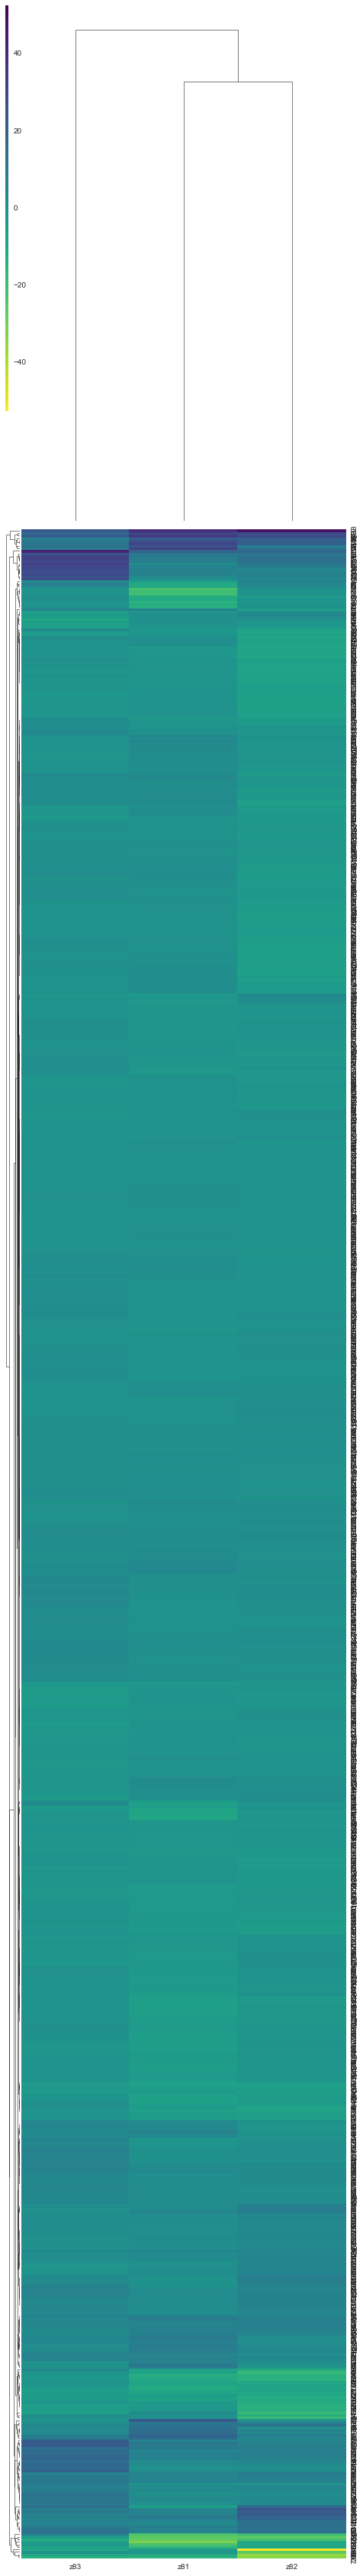

In [37]:
g = sns.clustermap(trunc_james_data[['z81', 'z82', 'z83']], 
                   cmap = cm.viridis_r,
                   figsize = (8, 60))